In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from sympy.physics.vector import dynamicsymbols
from sympy import symbols, cos, sin, diff, sqrt, init_printing, latex, Symbol, Eq, solve, lambdify, print_latex, simplify, cse
from scipy.integrate import solve_ivp
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"

# Make printouts look nicer
latexReplaceRules = {
    r'{\left(t \right)}':r' ',
    r'\frac{d}{d t}':r'\dot',
    r'\frac{d^{2}}{d t^{2}}':r'\ddot',
}
def latexNew(expr,**kwargs):
    retStr = latex(expr,**kwargs)
    for _,__ in latexReplaceRules.items():
        retStr = retStr.replace(_,__)
    return retStr
init_printing(latex_printer=latexNew)

In [2]:
G, M, omega, m, m0, f, a, d, e, tau = symbols(r"G, M, \Omega, m_\oplus, m_0, f, a, d, e \tau", real=True, positive=True)

t=Symbol('t')

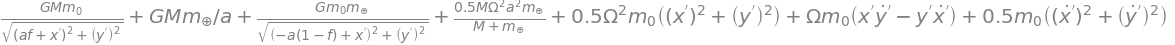

In [3]:
x, y = dynamicsymbols("x^', y^'", real=True)
x_dot = x.diff()
y_dot = y.diff()

L = (1/2) * (M*m)/(M+m) * a**2 * omega**2 + (1/2)*m0*(x_dot**2 + y_dot**2) + (1/2)*m0*omega**2*(x**2+y**2) + m0*omega *(x*y_dot - x_dot*y) + (G*M*m)/a + (G*M*m0)/(sqrt((x+f*a)**2 + y**2)) + (G*m*m0)/(sqrt((x-(1-f)*a)**2 + y**2))
L

In [4]:
x_derivative = L.diff(x)
x_dot_derivative = L.diff(x_dot) #same as what Prof Tamayo gets!
x_dot_second_derivative = x_dot_derivative.diff(t)

# Euler-Lagrange Equation for x 
ELx = Eq(x_derivative- x_dot_second_derivative, 0)
x_dot_second_derivative

In [5]:
y_derivative = L.diff(y)
y_dot_derivative = L.diff(y_dot) #same as what Prof Tamayo gets!
y_dot_second_derivative = y_dot_derivative.diff(t)

# Euler-Lagrange Equation for y
ELy = Eq(y_derivative- y_dot_second_derivative, 0)

y_dot_second_derivative

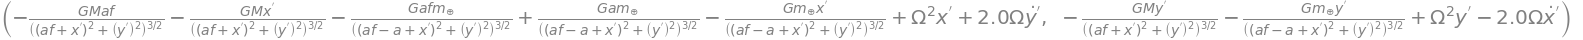

In [8]:
# Isolating x & y double dot
x_doubledot= solve(ELx, x_dot.diff(t))[0] 
y_doubledot= solve(ELy, y_dot.diff(t))[0]

x_doubledot, y_doubledot

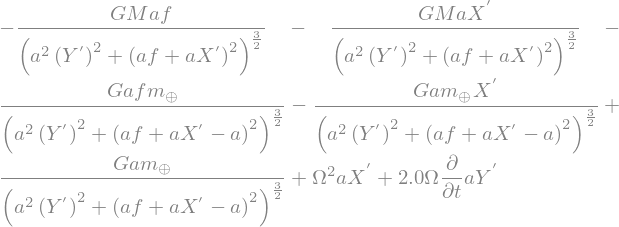

In [ ]:
# attempt at nondimensionalization
X, Y = dynamicsymbols("X^', Y^'", real=True)
X_dot = X.diff()
Y_dot = Y.diff()
x_doubledot.subs(((x, X*a),(y, Y*a))).subs(G*M/a**3,e)

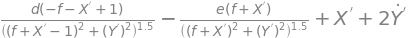

In [9]:
#nondimensionalization for x=X*a, tau=t*omega

#L=L.subs(omega*t, tau) #this is the nondimensionalization step w/ tau=t*omega 

#x_doubledot=x_doubledot.subs()

X, Y = dynamicsymbols("X^', Y^'", real=True)
X_dot = X.diff()
Y_dot = Y.diff()

X_doubledot=2*Y.diff() + X +d*(1-X-f)/((f-1+X)**2 +Y**2)**(3/2) -e*(X+f)/((f+X)**2+Y**2)**(3/2)


X_doubledot

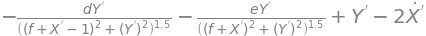

In [10]:
Y_doubledot=-2*X.diff() + Y -d*Y/((f-1+X)**2 +Y**2)**(3/2) -e*(Y)/((f+X)**2+Y**2)**(3/2)

Y_doubledot

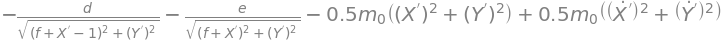

In [14]:
hamiltonian = (1/2) * m0* (X_dot**2 + Y_dot**2) - (1/2)*m0*(X**2+Y**2) -e/sqrt((X+f)**2 + Y**2) - d/sqrt((X+(f-1))**2 + Y**2)
hamiltonian

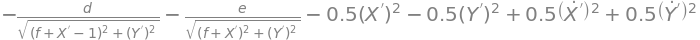

In [13]:
#this is for the nondimensionalized hamiltonian h

h=0.5*(X_dot**2 +Y_dot**2) -0.5*(X**2+Y**2) -e/sqrt((X+f)**2+Y**2) -d/sqrt((X-(1-f))**2+Y**2)

h

In [30]:
# lambdify, give eq in terms of variables, gives its inputs, then lets you input the inputs in the expression. So turn symbolic math into python function 


gx = lambdify((X, Y, Y_dot, d, e, f), X_doubledot, 'numpy') #Before, python solved for X dot dot and Y dot dot. So, this puts that as a function, so we can use it later for our DE. 
fy = lambdify([X, X_dot, Y, d, e, f], Y_doubledot, 'numpy')

H = lambdify([X, X_dot, Y, Y_dot, d, e, f], h, 'numpy') #took away m0 bc not hamiltonian...

def three_body_prob(tau, Z, d, e, f): #Not sure why we need it, but I added tau back in.
    X, w, Y, z = Z #separates Z into 4 variables, corresponding to X, X dot, Y, Y dot. So...I guess Z is supposed to be a list? 

    X_dot = w
    Y_dot = z
    w_dot = gx(X, Y, Y_dot, d, e, f)
    z_dot = fy(X, X_dot, Y, d, e, f)

    return X_dot, w_dot, Y_dot, z_dot

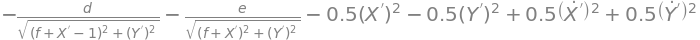

In [31]:
h

In [32]:
#gives some basic parameters 

# M=10e30
# me=10e24
# G=10e-12
# a=10e11
# Omega= 10e-7

M=100
me=10
G=0.1
a=10
Omega= 1

d1=G*me /(Omega*2 *a*3) #I added the ones 'cause I'm not sure if python can distinguish these actual values and the placeholder ones. 

e1=G*M /(Omega*2 *a*3)

f1=me/(M+me)



In [33]:
#solving the differential equation

#t_eval=t does more intermediate positions

t_eval = np.linspace(0, 10, 1000) #a range, specifies gaps between numbers. linspace gives start, end, jump. Don't think is necessary, 'cause we don't have time, tho.
#Not really sure what t means, here.... I guess it's tau. So we can maybe multiply by omega later or something to get back to actual time? 


initial_conditions= [6, 0, 0, 0] #X initial, Y initial, X dot initial, Y dot initial. This is Z!!! 
#args = (1, 1000, 10, 100, 100) # ma, M, me, G, a

args= (d1, e1, f1) #this is just d, e, f, so we can insert this into three_body_prob. 

sol = solve_ivp(three_body_prob, (np.min(t_eval), np.max(t_eval)), initial_conditions, args=args, t_eval=t_eval) #in the same order as defined above. Just returns the times you ask for. Goes like: function, interval, initial conditions, optional arguments
xa, wa, ya, za = sol.y #why is this sol.y? 
t_eval = sol.t

#Why is the derivative not defined, when I thought I defined it in Z above? 

#maybe I'm getting these errors bc the original function is wrong?

# f_sub = ELsubs[f].subs([(M, args[1]), (me, args[0])]).evalf()
# a_sub = args[4]

# xs = -f_sub * a_sub * np.cos(t_eval)
# ys = -f_sub * a_sub * np.sin(t_eval)

# xe = (1-f_sub) * a_sub * np.cos(t_eval)
# ye = (1-f_sub) * a_sub * np.sin(t_eval)

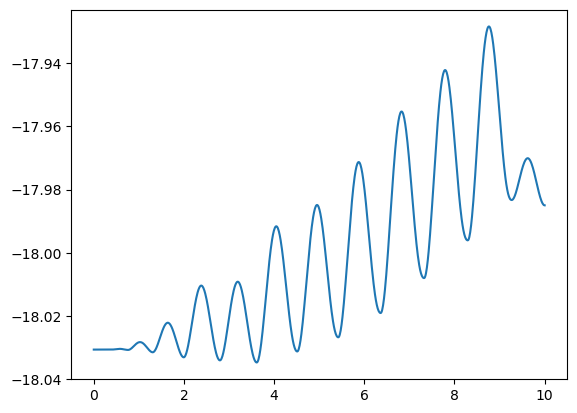

In [35]:
plt.plot(t_eval, H(xa, wa, ya, za, d1, e1, f1))

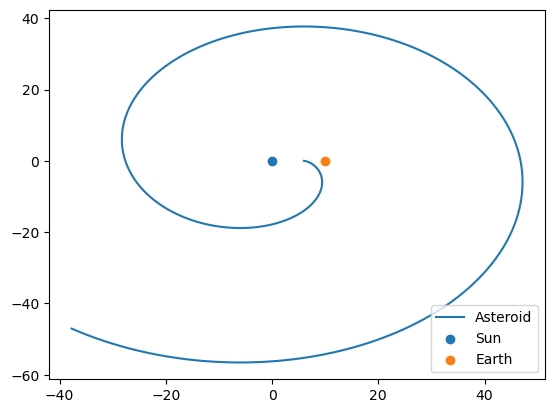

In [19]:
plt.plot(xa, ya, label="Asteroid")

plt.scatter(0, 0, label="Sun")
plt.scatter(a, 0, label="Earth")
plt.legend()